In [1]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [2]:
# Define constants
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 20

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Path to the extracted "data" directory
data_path = '/content/drive/MyDrive/Breast Cancer Dataset'

# Paths to the extracted "benign" and "malignant" directories
benign_path = os.path.join(data_path, 'benign')
malignant_path = os.path.join(data_path, 'malignant')

# Check if the directories exist
print("Normal directory exists:", os.path.isdir(benign_path))
print("Tumor directory exists:", os.path.isdir(malignant_path))

Normal directory exists: True
Tumor directory exists: True


In [5]:
# Get the current working directory
current_directory = os.getcwd()

# Print the current working directory
print("Current working directory:", current_directory)

Current working directory: /content


In [6]:
# Check if directories exist
print("Benign directory exists:", os.path.isdir(benign_path))
print("Malignant directory exists:", os.path.isdir(malignant_path))

Benign directory exists: True
Malignant directory exists: True


In [7]:
import glob
# Load the list of filenames from the directories using glob
benign_filenames = glob.glob(os.path.join(benign_path, '*.png'))  # Adjust the file extension if needed
malignant_filenames = glob.glob(os.path.join(malignant_path, '*.png'))    # Adjust the file extension if needed

In [8]:
len(benign_filenames)

547

In [9]:
len(malignant_filenames)

1156

In [10]:
# Combine the filenames and create labels
filenames = benign_filenames + malignant_filenames
labels = ['benign'] * len(benign_filenames) + ['malignant'] * len(malignant_filenames)

In [11]:

# Split the data into training and testing sets
train_filenames, test_filenames, train_labels, test_labels = train_test_split(
    filenames, labels, test_size=0.2, random_state=42, stratify=labels)

In [12]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    data_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    data_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    data_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 1363 images belonging to 2 classes.
Found 340 images belonging to 2 classes.
Found 1703 images belonging to 2 classes.


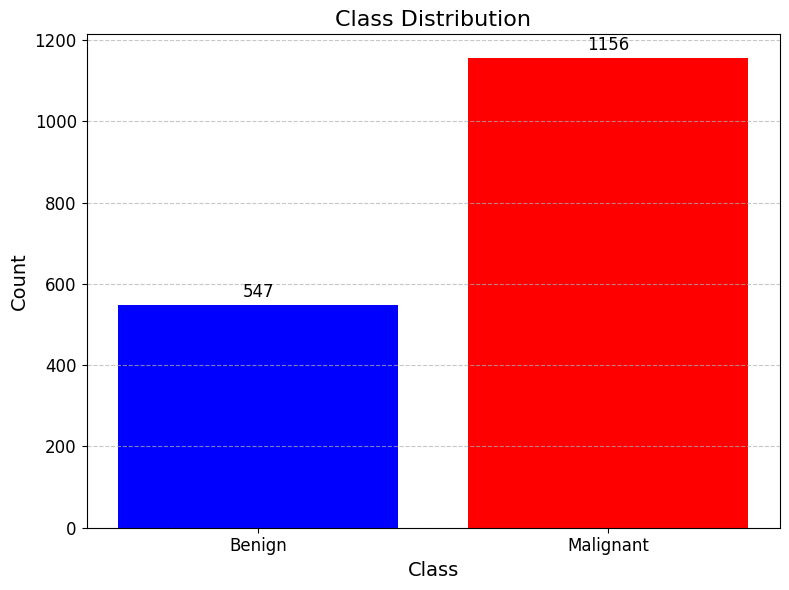

In [13]:
import matplotlib.pyplot as plt

class_labels = ['Benign', 'Malignant']
class_counts = [len(benign_filenames), len(malignant_filenames)]
colors = ['blue', 'red']

plt.figure(figsize=(8, 6))
plt.bar(class_labels, class_counts, color=colors)

for i, count in enumerate(class_counts):
    plt.text(i, count + 20, str(count), ha='center', fontsize=12)

plt.xlabel('Class', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Class Distribution', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

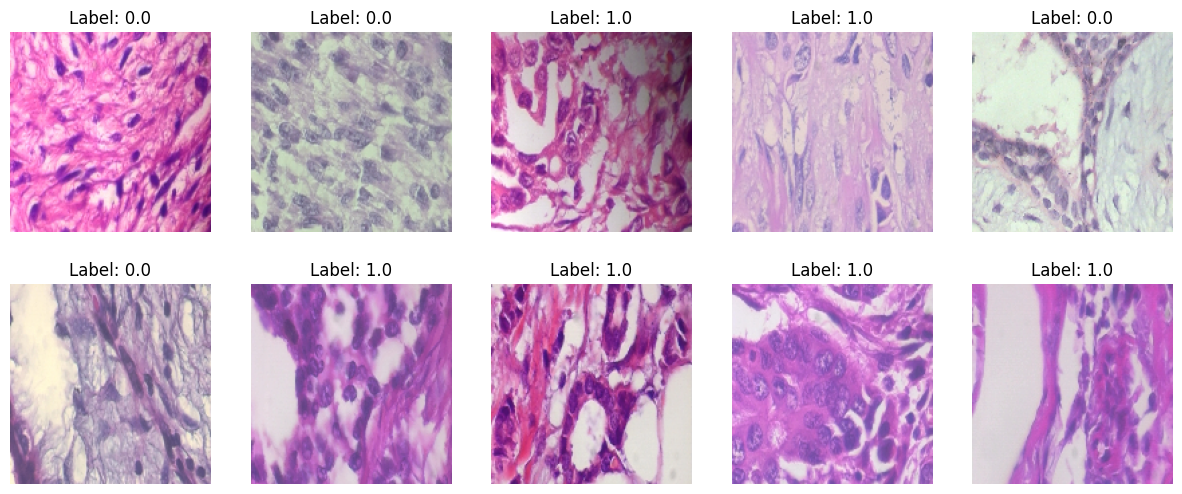

In [14]:
sample_images, sample_labels = train_generator.next()
sample_images = sample_images[:10]
sample_labels = sample_labels[:10]

plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(sample_images[i])
    plt.title('Label: {}'.format(sample_labels[i]))
    plt.axis('off')
plt.show()

In [15]:
import numpy as np
# Image Statistics
mean_pixel_intensity = np.mean(sample_images)
std_pixel_intensity = np.std(sample_images)

print('Mean Pixel Intensity:', mean_pixel_intensity)
print('Standard Deviation of Pixel Intensity:', std_pixel_intensity)

Mean Pixel Intensity: 0.6874412
Standard Deviation of Pixel Intensity: 0.17997974


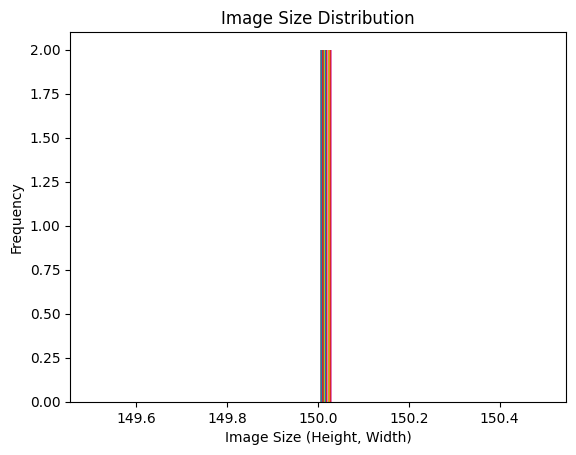

In [16]:
image_sizes = []
for i in range(len(train_generator)):
    batch_images, _ = train_generator[i]
    for image in batch_images:
        image_sizes.append(image.shape[:2])

plt.hist(image_sizes, bins=30)
plt.xlabel('Image Size (Height, Width)')
plt.ylabel('Frequency')
plt.title('Image Size Distribution')
plt.show()

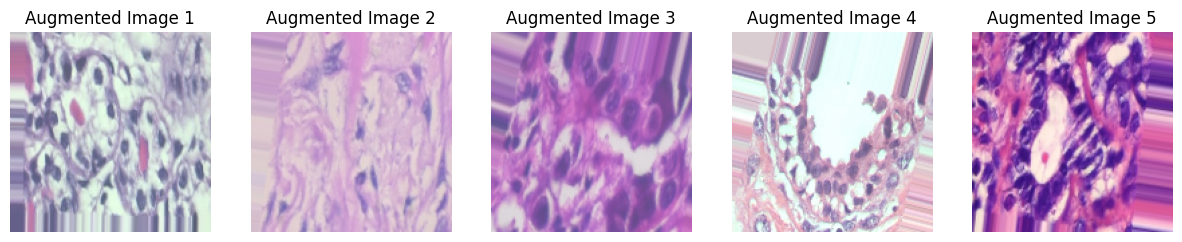

In [17]:
data_augmentation = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

augmented_images, _ = next(data_augmentation.flow(train_generator.next(), batch_size=5))

plt.figure(figsize=(15, 6))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(augmented_images[i])
    plt.title('Augmented Image {}'.format(i + 1))
    plt.axis('off')
plt.show()

In [18]:
# Define the CNN model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [19]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [27]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

In [28]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    batch_size=64,
    callbacks=[early_stopping]
)

Epoch 1/20
43/43 [==============================] - 101s 2s/step - loss: 0.2882 - accuracy: 0.8877 - val_loss: 0.9688 - val_accuracy: 0.6882
Epoch 2/20
43/43 [==============================] - 104s 2s/step - loss: 0.3085 - accuracy: 0.8635 - val_loss: 0.4236 - val_accuracy: 0.8235
Epoch 3/20
43/43 [==============================] - 100s 2s/step - loss: 0.2838 - accuracy: 0.8870 - val_loss: 0.5123 - val_accuracy: 0.7941
Epoch 4/20
43/43 [==============================] - 100s 2s/step - loss: 0.3336 - accuracy: 0.8716 - val_loss: 0.3780 - val_accuracy: 0.8235
Epoch 5/20
43/43 [==============================] - 99s 2s/step - loss: 0.2935 - accuracy: 0.8767 - val_loss: 1.2224 - val_accuracy: 0.6912
Epoch 6/20
43/43 [==============================] - 111s 3s/step - loss: 0.2731 - accuracy: 0.8929 - val_loss: 0.5431 - val_accuracy: 0.8471
Epoch 7/20
43/43 [==============================] - 114s 3s/step - loss: 0.2664 - accuracy: 0.8877 - val_loss: 0.6237 - val_accuracy: 0.7765
Epoch 8/20
43/

In [29]:
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print('Test accuracy:', test_acc)

54/54 [==============================] - 56s 1s/step - loss: 0.2308 - accuracy: 0.9196
Test accuracy: 0.9195537567138672


In [30]:
accuracy_percentage = test_acc * 100

print('Test accuracy:', accuracy_percentage, '%')

Test accuracy: 91.95537567138672 %


In [31]:
from keras.models import load_model
model.save('bcd_model.h5')


In [32]:

import os
import pickle
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('bcd_model.h5')

# Save the model using pickle
with open('bcd_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Load the model using pickle
with open('bcd_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)


In [33]:
import os
import pickle
from tensorflow.keras.models import load_model
from keras.preprocessing import image
import numpy as np
import ipywidgets as widgets
from IPython.display import display

# Function to handle uploaded image
def handle_upload(change):
    uploaded_filename = next(iter(change['new']))
    content = change['new'][uploaded_filename]['content']
    with open('uploaded_image.png', 'wb') as f:
        f.write(content)
    process_image('uploaded_image.png')

# Function to preprocess and predict
def process_image(img_path):
    img = image.load_img(img_path, target_size=(150, 150)) # Match your model input size
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale pixel values

    prediction = model.predict(img_array)
    print(prediction)  # Print the prediction result

    if prediction[0][0] > 0.5:
        print('Prediction: Malignant')
    else:
        print('Prediction: Benign')

# Create upload widget
uploader = widgets.FileUpload()
display(uploader)

# Observe changes in the upload widget
uploader.observe(handle_upload, names='value')

FileUpload(value={}, description='Upload')

1/1 [==============================] - 0s 213ms/step
[[0.45232671]]
Prediction: Benign
1/1 [==============================] - 0s 34ms/step
[[0.9720226]]
Prediction: Malignant


In [34]:
from google.colab import files
files.download('bcd_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>